In [1]:
# https://platform.olimpiada-ai.ro/en/problems/83

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [2]:
train = pd.read_csv("/kaggle/input/arbins-lands/train.csv")
test = pd.read_csv("/kaggle/input/arbins-lands/test.csv")

train.shape, test.shape

((400, 2), (100, 1))

In [3]:
train.head()

,id,type
0,train_images/f0935e4c.png,0
1,train_images/45c48cce.png,1
2,train_images/7f39f831.png,1
3,train_images/13fe9d84.png,0
4,train_images/a5bfc9e0.png,1


In [4]:
train['type'].value_counts()

type
0    200
1    200
Name: count, dtype: int64

In [5]:
test.head()

,id
0,test_images/cfcd2084.png
1,test_images/c4ca4238.png
2,test_images/c81e728d.png
3,test_images/eccbc87e.png
4,test_images/a87ff679.png


In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.2, stratify=train['type'], random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

train.shape, valid.shape

((320, 2), (80, 2))

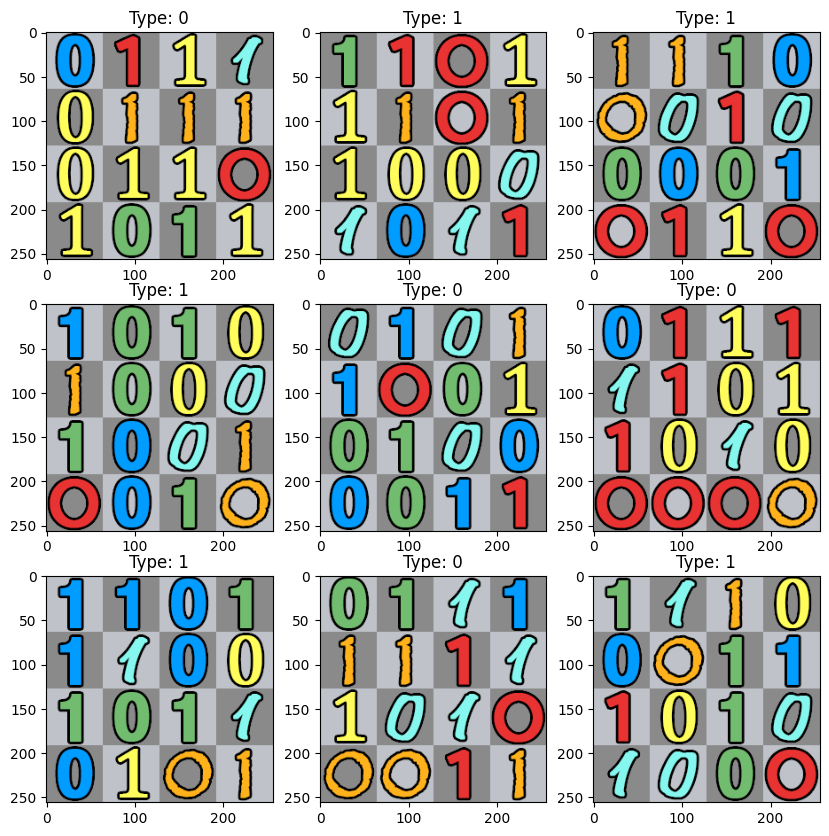

In [7]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)

for i, ax in zip(np.random.choice(range(len(train)), size=9, replace=False), axes.flatten()):
    ax.imshow(Image.open(os.path.join('/kaggle/input/arbins-lands', train['id'][i])))
    ax.set_title(f'Type: {train['type'][i]}')

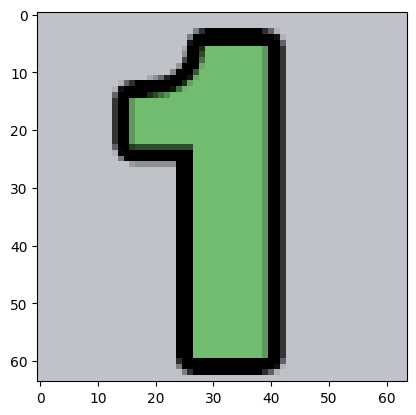

In [8]:
plt.imshow(np.array(Image.open(os.path.join('/kaggle/input/arbins-lands', train['id'][0])))[:64, :64, :3])

In [9]:
class DigitsDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = np.array(Image.open(os.path.join('/kaggle/input/arbins-lands', self.df['id'][idx])))[:64, :64, :3]
        if self.transform is not None:
            aug = self.transform(image=img)
            img = aug['image']

        if self.is_test:
            return img
        
        label = self.df['type'][idx]
        
        return img, float(label)

In [10]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ChannelShuffle(p=0.8),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

train_ds = DigitsDataset(train, train_transforms)
valid_ds = DigitsDataset(valid, valid_transforms)
test_ds = DigitsDataset(test, valid_transforms, is_test=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(10, 3, 4)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(), 
    nn.MaxPool2d(2), # [4, 32, 32]
    
    nn.Conv2d(4, 8, kernel_size=3, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(), 
    nn.MaxPool2d(2), # [8, 16, 16]

    nn.Flatten(),
    nn.Linear(8*16*16, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 1)
)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [13]:
epochs, log_rate = 10, 1

history = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': []
}

for epoch in tqdm(range(epochs), desc='Epoch'):
    model.train()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(train_loader, desc='Train Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        output = model(X).squeeze()
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).to(int)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        rloss += loss.item()
        correct += (y==preds).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})

    history['train_loss'].append(rloss/i)
    history['train_acc'].append(correct/total)

    if (epoch+1)%log_rate==0:
        print(f'Epoch: {epoch+1}{epochs}')
        print(f'Train Loss: {rloss/i:.5f} | Train Acc: {correct/total:.5f}')

    model.eval()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(valid_loader, desc='Valid Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            output = model(X).squeeze()
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).to(int)
            loss = criterion(output, y)

        i += 1
        rloss += loss.item()
        correct += (y==preds).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})
        
    history['valid_loss'].append(rloss/i)
    history['valid_acc'].append(correct/total)

    if (epoch+1)%log_rate==0:
        print(f'Valid Loss: {rloss/i:.5f} | Valid Acc: {correct/total:.5f}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 110
Train Loss: 0.64700 | Train Acc: 0.64062


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.62554 | Valid Acc: 0.98750


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 210
Train Loss: 0.52610 | Train Acc: 0.95000


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.51303 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 310
Train Loss: 0.42450 | Train Acc: 1.00000


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.38856 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 410
Train Loss: 0.36278 | Train Acc: 0.99687


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.29478 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 510
Train Loss: 0.28880 | Train Acc: 1.00000


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.22968 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 610
Train Loss: 0.23523 | Train Acc: 0.99687


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.17801 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 710
Train Loss: 0.19126 | Train Acc: 1.00000


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.14022 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 810
Train Loss: 0.16994 | Train Acc: 0.99687


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.11169 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 910
Train Loss: 0.13180 | Train Acc: 1.00000


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.09319 | Valid Acc: 1.00000


Train Loader:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1010
Train Loss: 0.11861 | Train Acc: 0.99687


Valid Loader:   0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss: 0.08252 | Valid Acc: 1.00000


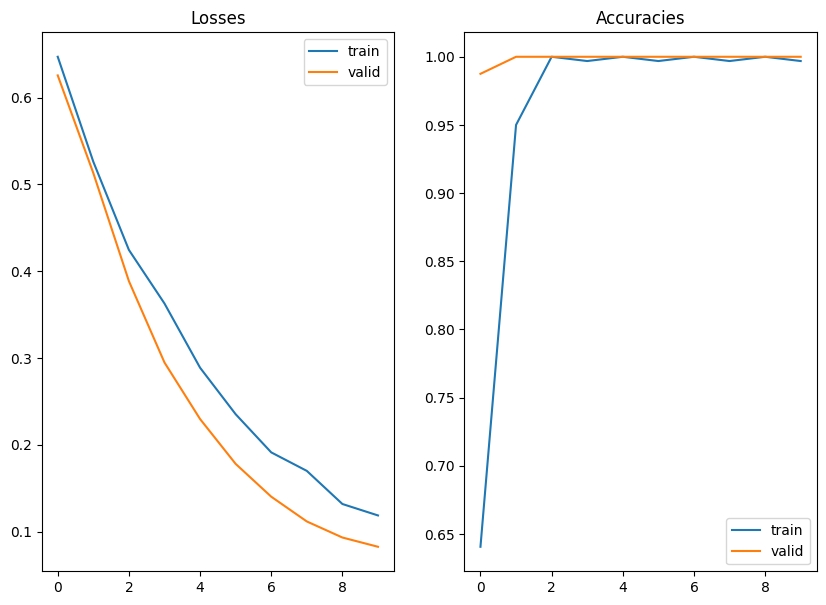

In [14]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(range(epochs), history['train_loss'], label='train')
plt.plot(range(epochs), history['valid_loss'], label='valid')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracies')
plt.plot(range(epochs), history['train_acc'], label='train')
plt.plot(range(epochs), history['valid_acc'], label='valid')
plt.legend()

plt.show()

In [15]:
def receive_prediction(X):
    X = X.to(device)
    with torch.no_grad():
        output = model(X).squeeze()
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).to(int).view(-1).item()
    return preds

def binary_to_signed(digits_list):
    n = len(digits_list)
    value = 0
    for i, bit in enumerate(digits_list):
        value = (value << 1) | bit

    if digits_list[0] == 1:
        value -= 1 << n
    return value

def get_answer(path):
    img = np.array(Image.open(os.path.join('/kaggle/input/arbins-lands', path)))[:, :, :3]
    img = valid_transforms(image=img)['image']
    digits_list = []

    for i in range(4):
        for j in range(4):
            img_part = img[:, i*64:(i+1)*64, j*64:(j+1)*64]
            digits_list.append(receive_prediction(img_part.unsqueeze(0)))

    answer = binary_to_signed(digits_list)
    
    return digits_list[0], answer

In [16]:
answers = []
left_upper_digits = []

for path in tqdm(test['id'], desc='Inference'):
    left_upper_digit, answer = get_answer(path)
    left_upper_digits.append(left_upper_digit)
    answers.append(answer)

Inference:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
subm = pd.DataFrame({
    'subtaskID': [1] * len(test) + [2] * len(test),
    'ID': test['id'].tolist() * 2,
    'answer': left_upper_digits + answers
})

subm.to_csv("submission.csv", index=False)
subm.head()

,subtaskID,ID,answer
0,1,test_images/cfcd2084.png,0
1,1,test_images/c4ca4238.png,1
2,1,test_images/c81e728d.png,0
3,1,test_images/eccbc87e.png,0
4,1,test_images/a87ff679.png,1
